<a href="https://colab.research.google.com/github/Raghad-Odwan/Dataset-Full-Project/blob/main/DermAI_AI_Model_Training_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DermAI_AI_Model_Training .ipynb

###  **Notebook Overview**

This notebook is structured into two main parts:

##### **✅Part 1 — Dataset Preparation & Preprocessing**
In this section, the dataset (≈19,600 dermatoscopic images) is loaded, explored, and organized into two main categories:
- **Benign (13,294 images)**
- **Malignant (6,211 images)**  
Data preprocessing includes cleaning, resizing, normalization, and augmentation to ensure robust model generalization and balance during training.

##### **✅Part 2 — Model Training, Validation & Evaluation**
This section covers the **training pipeline** of the model using **3-Fold Stratified Cross Validation**.  
The model (based on *EfficientNetB0 / ResNet50*) is trained to classify the images into *benign* or *malignant* lesions.  
Performance metrics such as **Accuracy**, **Precision**, **Recall**, and **F1-Score** are calculated for each fold.  
Additionally, **Grad-CAM visualizations** are generated to explain the model’s predictions and highlight the lesion areas influencing its decisions.  
The results are summarized and saved for reporting within the project documentation.


# **Dataset Preparation & Preprocessing**

## **DermAI** — Dataset Cleaning & Preprocessing

#### Uploading the dataset from Google Drive and extracted Dataset


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# extracted Dataset
import zipfile
import os

zip_path = "/content/drive/MyDrive/Dataset.zip"
extract_path = "/content/Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")
os.listdir(extract_path)

Dataset extracted successfully!


['Dataset']

In [7]:
dataset_path = "/content/Dataset/Dataset"

for item in os.listdir(dataset_path):
    print(item)

benign
duplicates_or_corrupted
malignant


#### Initialize the environment and import required libraries

In [8]:
!pip install -q --upgrade "tqdm>=4.67" "opencv-python-headless>=4.9.0.80" "albumentations>=1.3.1"

In [9]:
# Import libraries
import os
import shutil
import hashlib
import random
import math
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
from pathlib import Path
from collections import defaultdict
from datetime import datetime

# Ignore warnings
warnings.filterwarnings('ignore')

### **Data Cleaning and Exploration**

In [10]:
base_dir = "/content/Dataset/Dataset"
folders = ["benign", "malignant"]


In [11]:
# Create a folder for corrupted or duplicate images
dup_dir = os.path.join(base_dir, "duplicates_or_corrupted")
os.makedirs(dup_dir, exist_ok=True)

print("Base directory:", base_dir)
print("Duplicate/Corrupted folder created at:", dup_dir)

Base directory: /content/Dataset/Dataset
Duplicate/Corrupted folder created at: /content/Dataset/Dataset/duplicates_or_corrupted


##### Data Cleaning and Quality Verification

In [12]:
class ImageCleaner:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.folders_to_check = ['benign', 'malignant']

        # Create folder for problematic files
        self.problem_folder = self.base_path / 'duplicates_or_corrupted'
        self.problem_folder.mkdir(exist_ok=True)

        # Statistics
        self.stats = {
            'total_checked': 0,
            'corrupted': 0,
            'duplicates': 0,
            'low_quality': 0,
            'healthy': 0
        }

        # Store image hashes
        self.image_hashes = defaultdict(list)

    def calculate_hash(self, image_path):
        try:
            hasher = hashlib.md5()
            with open(image_path, 'rb') as f:
                buf = f.read()
                hasher.update(buf)
            return hasher.hexdigest()
        except Exception as e:
            print(f"Error calculating hash: {image_path} - {e}")
            return None

    def is_image_corrupted(self, image_path):
        try:
            with Image.open(image_path) as img:
                img.verify()

            with Image.open(image_path) as img:
                img.load()

            return False
        except Exception:
            return True

    def check_image_quality(self, image_path, min_width=50, min_height=50):
        try:
            with Image.open(image_path) as img:
                width, height = img.size

                if width < min_width or height < min_height:
                    return False

                file_size = os.path.getsize(image_path)
                if file_size < 1000:
                    return False

            return True
        except Exception:
            return False

    def move_to_problem_folder(self, image_path):
        try:
            source_folder = image_path.parent.name
            dest_subfolder = self.problem_folder / source_folder
            dest_subfolder.mkdir(exist_ok=True)

            destination = dest_subfolder / image_path.name

            if destination.exists():
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                destination = dest_subfolder / f"{image_path.stem}_{timestamp}{image_path.suffix}"

            shutil.move(str(image_path), str(destination))

        except Exception as e:
            print(f"Error moving file: {image_path.name} - {e}")

    def clean_folder(self, folder_name):
        folder_path = self.base_path / folder_name

        if not folder_path.exists():
            print(f"Folder not found: {folder_name}")
            return

        print(f"Processing: {folder_name}...", end=' ')

        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']
        images = [f for f in folder_path.iterdir()
                 if f.is_file() and f.suffix.lower() in image_extensions]

        for img_path in images:
            self.stats['total_checked'] += 1

            # Check corruption
            if self.is_image_corrupted(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['corrupted'] += 1
                continue

            # Check quality
            if not self.check_image_quality(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['low_quality'] += 1
                continue

            # Check duplicates
            img_hash = self.calculate_hash(img_path)
            if img_hash:
                if img_hash in self.image_hashes:
                    self.move_to_problem_folder(img_path)
                    self.stats['duplicates'] += 1
                else:
                    self.image_hashes[img_hash].append(str(img_path))
                    self.stats['healthy'] += 1

        print(f"Done ({len(images)} images checked)")

    def clean_all(self):
        print("\n" + "="*60)
        print("Starting cleaning process")
        print("="*60)

        for folder in self.folders_to_check:
            self.clean_folder(folder)

        self.print_summary()

    def print_summary(self):
        print("\n" + "="*60)
        print("Cleaning Summary")
        print("="*60)
        print(f"Total checked: {self.stats['total_checked']}")
        print(f"Healthy images: {self.stats['healthy']}")
        print(f"Corrupted: {self.stats['corrupted']}")
        print(f"Duplicates: {self.stats['duplicates']}")
        print(f"Low quality: {self.stats['low_quality']}")
        print(f"\nProblematic files moved to: {self.problem_folder}")
        print("="*60)


# For Google Colab - use the path you already created
base_path = "/content/Dataset/Dataset"

# Check if path exists
if not os.path.exists(base_path):
    print(f"Error: Path does not exist: {base_path}")
    print("Current working directory:", os.getcwd())
    print("\nAvailable folders:")
    if os.path.exists("/content/Dataset"):
        print(os.listdir("/content/Dataset"))
else:
    print(f"Base path found: {base_path}")
    print(f"Contents: {os.listdir(base_path)}")

    cleaner = ImageCleaner(base_path)
    cleaner.clean_all()
    print("\nCleaning completed successfully!")

Base path found: /content/Dataset/Dataset
Contents: ['benign', 'duplicates_or_corrupted', 'malignant']

Starting cleaning process
Processing: benign... Done (13294 images checked)
Processing: malignant... Done (6211 images checked)

Cleaning Summary
Total checked: 19505
Healthy images: 19505
Corrupted: 0
Duplicates: 0
Low quality: 0

Problematic files moved to: /content/Dataset/Dataset/duplicates_or_corrupted

Cleaning completed successfully!


Images per class:
Benign: 13294
Malignant: 6211
Total: 19505


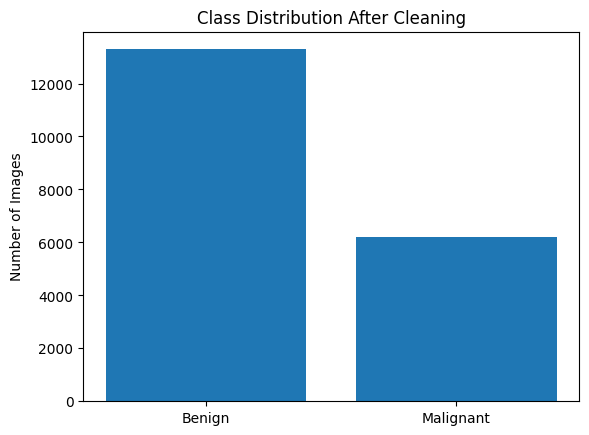

In [13]:
import os
import matplotlib.pyplot as plt

base_path = "/content/Dataset/Dataset"

count_benign = len(os.listdir(os.path.join(base_path, "benign")))
count_malignant = len(os.listdir(os.path.join(base_path, "malignant")))

print("Images per class:")
print("Benign:", count_benign)
print("Malignant:", count_malignant)
print("Total:", count_benign + count_malignant)

plt.bar(["Benign", "Malignant"], [count_benign, count_malignant])
plt.title("Class Distribution After Cleaning")
plt.ylabel("Number of Images")
plt.show()

##### Data preprocessing (resizing, split)

In [14]:
import cv2
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
BASE_DIR = "/content/Dataset/Dataset"
FOLDERS = ["benign", "malignant"]
IMG_SIZE = (224, 224)
RANDOM_STATE = 42

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SPLIT_ROOT = os.path.join(BASE_DIR)

In [16]:
# Resize all images to 224x224 and overwrite the originals as JPG files
for cat in FOLDERS:
    src_dir = os.path.join(BASE_DIR, cat)
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]

    for fname in tqdm(files, desc=f"Resizing {cat}"):
        src_path = os.path.join(src_dir, fname)
        try:
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue


            # read image
            img = cv2.imread(src_path)
            if img is None:
                print(f" Skipped unreadable file: {fname}")
                continue

            # resize image
            resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

            # save resized image as JPG (overwrite or replace)
            base_name = os.path.splitext(fname)[0]
            save_name = base_name + ".jpg"
            save_path = os.path.join(src_dir, save_name)
            cv2.imwrite(save_path, resized)

            # remove original file if extension changed
            if save_path != src_path:
                os.remove(src_path)

        except Exception as e:
            print(f" Skipped {fname} due to error: {e}")

Resizing malignant: 100%|██████████| 6211/6211 [00:03<00:00, 1558.20it/s]


**Split dataset: 70% train, 15% val, 15% test**


In [17]:
import os, shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [18]:
base_dir = "/content/Dataset/Dataset"
folders = ["benign", "malignant"]

split_dir = "/content/Dataset_split"
os.makedirs(split_dir, exist_ok=True)


# Collect all image file paths and labels
rows = []
for label in folders:
    path = os.path.join(base_dir, label)
    for fname in os.listdir(path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            rows.append({'path': os.path.join(path, fname), 'label': label})

df = pd.DataFrame(rows)
print("Total images found:", len(df))
print(df['label'].value_counts())

# Stratified split: 70% train, 15% val, 15% test
train_temp, test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train, val = train_test_split(train_temp, test_size=0.1765, stratify=train_temp['label'], random_state=42)
# 0.1765 of 85% ≈ 15% of total, resulting in 70/15/15 split

# Create destination folders for train, val, and test
for subset in ['train', 'val', 'test']:
    for label in folders:
        os.makedirs(os.path.join(split_dir, subset, label), exist_ok=True)

# Copy images to their corresponding subset folders
def copy_images(df_subset, subset_name):
    print(f"\nCopying {subset_name} set ({len(df_subset)} images)...")
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
        dest = os.path.join(split_dir, subset_name, row['label'], os.path.basename(row['path']))
        shutil.copy2(row['path'], dest)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

# Print summary
print("\n Dataset split completed successfully!")
print(f"Train: {len(train)} images")
print(f"Val:   {len(val)} images")
print(f"Test:  {len(test)} images")

print("\nClass distribution per set:")
print("Train:\n", train['label'].value_counts())
print("\nVal:\n", val['label'].value_counts())
print("\nTest:\n", test['label'].value_counts())

Total images found: 19505
label
benign       13294
malignant     6211
Name: count, dtype: int64

Copying train set (13652 images)...


100%|██████████| 13652/13652 [00:03<00:00, 4112.86it/s]



Copying val set (2927 images)...


100%|██████████| 2927/2927 [00:00<00:00, 3090.70it/s]



Copying test set (2926 images)...


100%|██████████| 2926/2926 [00:00<00:00, 3114.07it/s]


 Dataset split completed successfully!
Train: 13652 images
Val:   2927 images
Test:  2926 images

Class distribution per set:
Train:
 label
benign       9305
malignant    4347
Name: count, dtype: int64

Val:
 label
benign       1995
malignant     932
Name: count, dtype: int64

Test:
 label
benign       1994
malignant     932
Name: count, dtype: int64


### Bulid Dataframe

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Count the number of image files in each class folder (benign and malignant)
# This function walks through all subdirectories and counts only valid image files.
import os, sys, traceback
base_path = "/content/drive/MyDrive/Dataset/Dataset"

def count_images_in_folder(folder):
    exts = ('.jpg','.jpeg','.png','.bmp')
    cnt = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(exts):
                cnt += 1
    return cnt

for cls in ['benign','malignant']:
    p = os.path.join(base_path, cls)
    if not os.path.exists(p):
        print(f" WARNING: folder not found: {p}")
    else:
        print(f"{cls}: {count_images_in_folder(p):,} images")

benign: 13,294 images
malignant: 6,211 images


In [31]:
# build dataframe (paths + labels)
import pandas as pd

rows=[]
exts = ('.jpg','.jpeg','.png','.bmp')
for cls in ['benign','malignant']:
    folder = os.path.join(base_path, cls)
    if not os.path.exists(folder):
        continue
    for root, dirs, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(exts):
                rows.append({'path': os.path.join(root, fname), 'label': cls})

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['label_idx'] = df['label'].map({'benign':0, 'malignant':1})
print("Total samples:", len(df))
print(df['label'].value_counts())

Total samples: 19505
label
benign       13294
malignant     6211
Name: count, dtype: int64


In [36]:
#  quick corrupted-files check (lightweight, may take time if dataset big)
#  try to open the first N images from each class to detect obvious corruption
from PIL import Image
import random

def check_samples(df, n_per_class=20):
    corrupted = []
    for cls in df['label'].unique():
        paths = df[df['label']==cls]['path'].tolist()
        sample_paths = random.sample(paths, min(n_per_class, len(paths)))
        for p in sample_paths:
            try:
                img = Image.open(p)
                img.verify()   # fast integrity check
            except Exception as e:
                corrupted.append((p, str(e)))
    return corrupted

corrupted_examples = check_samples(df, n_per_class=30)  # adjust sample size if you want
if corrupted_examples:
    print(" Found corrupted or unreadable sample(s):", len(corrupted_examples))
    for p,err in corrupted_examples[:5]:
        print("-", p, "=>", err)
else:
    print(" Quick corrupted-sample check passed (no issues in sampled files).")


 Quick corrupted-sample check passed (no issues in sampled files).


In [37]:
# Save metadata CSV
out_csv = "/content/drive/MyDrive/ai/data/df_metadata.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False)
print(" Metadata saved to:", out_csv)

 Metadata saved to: /content/drive/MyDrive/ai/data/df_metadata.csv


In [32]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
